In [1]:
import pandas as pd
import numpy as np
from model import *
import extractor
class Extractor(extractor.AudioDataExtractionPipeline):
    pass

In [2]:
import pandas as pd
df = pd.read_csv("dataset/Data/features_30_sec.csv")
df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


In [3]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop(columns=['label'])  # Features: e.g., 'track' and 'statistics'
y = df['label']  # Target: 'label'

# Split the dataset while preserving class proportions
X_train, X_eval, y_train, y_eval = train_test_split(
    X, y, 
    test_size=0.3,  # 30% for testing
    stratify=y,     # Preserve class proportions
    random_state=42 # For reproducibility
)

In [4]:
# Drop corrupted sample 
idx = X_train.index[X_train["filename"] == "jazz.00054.wav"]
X_train = X_train.drop(index=idx)
y_train = y_train.drop(index=idx)

In [5]:
model, acc = train_and_evaluate_catboost(
    X_eval.index.to_numpy(), 
    X_train.drop(columns=["filename", "length"]).to_numpy(), 
    X_eval.drop(columns=["filename", "length"]).to_numpy(), 
    y_train.to_numpy(), 
    y_eval.to_numpy()
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3648069	test: 0.3433333	best: 0.3433333 (0)	total: 61ms	remaining: 30.5s
50:	learn: 0.7367668	test: 0.6566667	best: 0.6700000 (47)	total: 185ms	remaining: 1.63s
100:	learn: 0.8211731	test: 0.7200000	best: 0.7233333 (98)	total: 310ms	remaining: 1.23s
150:	learn: 0.8726753	test: 0.7300000	best: 0.7400000 (122)	total: 434ms	remaining: 1s
200:	learn: 0.9070100	test: 0.7366667	best: 0.7466667 (182)	total: 553ms	remaining: 823ms
250:	learn: 0.9313305	test: 0.7366667	best: 0.7533333 (218)	total: 667ms	remaining: 661ms
300:	learn: 0.9484979	test: 0.7533333	best: 0.7533333 (218)	total: 782ms	remaining: 517ms
350:	learn: 0.9670959	test: 0.7466667	best: 0.7600000 (318)	total: 897ms	remaining: 381ms
400:	learn: 0.9728183	test: 0.7466667	best: 0.7600000 (318)	total: 1.02s	remaining: 253ms
450:	learn: 0.9756795	test: 0.7400000	best: 0.7600000 (318)	total: 1.14s	remaining: 124ms
499:	learn: 0.9842632	test: 0.7466667	best: 0.7600000 (318)	total: 1.26s	remaining: 0us

bestTest = 0.76
bestIt

In [6]:
import soundfile as sf
import librosa
import numpy as np
from resampy import resample

In [7]:
E_train = Extractor(
    idx=[np.array([row[0]]) for row in X_train.iterrows()],
    x=[row[1].to_numpy() for row in X_train.iterrows()],
    y=[np.array([row]) for row in y_train],
    train=True
)
E_eval = Extractor(
    idx=[np.array([row[0]]) for row in X_eval.iterrows()],
    x=[row[1].to_numpy() for row in X_eval.iterrows()],
    y=[np.array([row]) for row in y_eval],
    train=False
)

def load_audio(x) -> [np.ndarray]:
    file_path = f"dataset/Data/genres_original/{x[0].split('.')[0]}/{x[0]}"
    y, sr = sf.read(file_path)
    if len(y.shape) == 2:  # Convert stereo to mono
        y = np.mean(y, dim=0)
    y = resample(y, sr, 16000)
    return y
Extractor.register_extractor('audio', load_audio)
E_train.full_extract()
E_eval.full_extract()

audio:   0%|          | 0/699 [00:00<?, ?it/s]

audio:   0%|          | 0/300 [00:00<?, ?it/s]

In [8]:
Extractor.register_extractor('stats', lambda x: x[2:])
Extractor.register_extractor('rms', lambda audio: np.array([np.sqrt(np.mean(audio**2))]))
E_train.soft_extract()
E_eval.soft_extract()

stats:   0%|          | 0/699 [00:00<?, ?it/s]

rms:   0%|          | 0/699 [00:00<?, ?it/s]

stats:   0%|          | 0/300 [00:00<?, ?it/s]

rms:   0%|          | 0/300 [00:00<?, ?it/s]

In [9]:
from librosa.sequence import viterbi

import numpy as np

def viterbi_dp(emission_probs, transition_matrix, p_init=None, eps=1e-15):
    """
    A custom Viterbi implementation that outputs:
      1) The DP table (log-domain) of best-path log-probs to each state/frame
      2) The state backpointer table
      3) A probability distribution over states at each time,
         obtained by exponentiating and normalizing the DP table
      4) The best-path state sequence from backtracking

    Parameters
    ----------
    emission_probs : np.ndarray [shape=(n_states, n_frames)]
        Probability (linear scale) of emitting each state at each frame.
        We will take the log of these values for the DP.
    transition_matrix : np.ndarray [shape=(n_states, n_states)]
        Probability (linear scale) of transitioning from state i to state j.
    p_init : np.ndarray [shape=(n_states,)]
        Initial state distribution (linear probabilities).
        If None, defaults to uniform.
    eps : float
        Small constant to avoid log(0).

    Returns
    -------
    dp : np.ndarray [shape=(n_states, n_frames)]
        dp[s, t] = log-prob of the best path that ends in state s at time t
    backpointer : np.ndarray [shape=(n_states, n_frames)]
        backpointer[s, t] = index of the best predecessor state for s at t
    state_probs : np.ndarray [shape=(n_states, n_frames)]
        Probability distribution over states for each frame
        (obtained via time-wise softmax of dp).
    best_path : np.ndarray [shape=(n_frames,)]
        The single best state for each frame (by Viterbi backtracking).
    """

    n_states, n_frames = emission_probs.shape

    if p_init is None:
        p_init = np.ones(n_states) / n_states

    # Convert input probabilities to log
    log_emit = np.log(emission_probs + eps)
    log_trans = np.log(transition_matrix + eps)
    log_init = np.log(p_init + eps)

    # Create storage
    dp = np.zeros((n_states, n_frames), dtype=np.float64)  # log of best path so far
    backpointer = np.zeros((n_states, n_frames), dtype=np.int32)

    # Initialization: time t=0
    dp[:, 0] = log_init + log_emit[:, 0]
    backpointer[:, 0] = 0  # no predecessor for the first frame

    # Forward pass
    for t in range(1, n_frames):
        for s in range(n_states):
            # Possible log-probs if we end in state s at time t
            candidates = dp[:, t-1] + log_trans[:, s]
            best_prev = np.argmax(candidates)
            dp[s, t] = candidates[best_prev] + log_emit[s, t]
            backpointer[s, t] = best_prev

    # Backtrack to find best path
    best_path = np.zeros(n_frames, dtype=np.int32)
    best_path[-1] = np.argmax(dp[:, -1])
    for t in range(n_frames - 2, -1, -1):
        best_path[t] = backpointer[best_path[t+1], t+1]

    # Convert dp to a per-frame probability distribution by exponentiating
    # and normalizing along the 'state' axis
    state_probs = np.zeros_like(dp, dtype=np.float64)
    for t in range(n_frames):
        # shift by max log-prob to avoid underflow
        row = dp[:, t]
        row_max = np.max(row)
        exp_row = np.exp(row - row_max)
        state_probs[:, t] = exp_row / np.sum(exp_row)

    return dp, backpointer, state_probs, best_path


def estimate_cqt_bin_viterbi(
    y,
    sr=22050,
    hop_length=512,
    n_bins=50,
    fmin=librosa.note_to_hz('C2'),
    silence_threshold=0.01,  # total energy below which we strongly favor silence
    stay_probability=0.9
):
    """
    Estimate the most likely CQT-bin sequence from an audio file, plus a
    special silence state. Use librosa's built-in Viterbi for smoothing.

    Parameters
    ----------
    audio_path : str
        Path to the audio file.
    sr : int
        Sample rate for loading the audio.
    hop_length : int
        Hop length for the CQT.
    n_bins : int
        Number of frequency bins in the CQT.
    fmin : float
        Minimum frequency for the CQT.
    silence_threshold : float
        Frames whose total energy is below this threshold are dominated by the silence state.
    stay_probability : float
        Probability of staying in the same state (bin or silence). The remainder
        is distributed across transitioning to all other states.

    Returns
    -------
    state_sequence : np.ndarray [shape=(n_frames,)]
        The best path of states (CQT bin indices plus one extra index for silence).
        Indices 0..(n_bins-1) correspond to actual bins; index n_bins is silence.
    path_log_probs : np.ndarray [shape=(n_frames,)]
        The log-probability of the best path up to (and including) each frame.
    emission_probs : np.ndarray [shape=(n_bins+1, n_frames)]
        The per-frame emission probability of each bin and the silence state.

    Notes
    -----
    - By default, `librosa.sequence.viterbi` expects probabilities in linear domain
      (non-log). We will manually compute the log-likelihood of the best path after
      we get the final state sequence.
    - The silence state (index = n_bins) has no direct column in the input,
      but we infer its emission probability by checking the total frame energy.
    """

    ################################################################
    # 1. Load audio and compute CQT magnitudes
    ################################################################
    cqt = librosa.cqt(y, sr=sr, hop_length=hop_length, n_bins=n_bins, fmin=fmin)
    cqt_mag = np.abs(cqt)  # shape = (n_bins, n_frames)
    n_frames = cqt_mag.shape[1]

    ################################################################
    # 2. Build emission probability matrix (n_bins + 1 states)
    #    - last row is "silence"
    ################################################################
    n_states = n_bins + 1
    silence_idx = n_bins

    emission_probs = np.zeros((n_states, n_frames), dtype=np.float32)

    for t in range(n_frames):
        frame_energy = np.sum(cqt_mag[:, t])

        if frame_energy < silence_threshold:
            # If total energy is below threshold, strongly favor silence
            # and place a minimal probability on actual bins
            emission_probs[:n_bins, t] = 1e-10  # negligible
            emission_probs[silence_idx, t] = 1.0
        else:
            # Distribute across the bins proportionally, plus a small portion for silence
            emission_probs[:n_bins, t] = cqt_mag[:, t]

            # Example: give silence a small probability if frame is not silent
            # You can tune this constant or use a ratio
            emission_probs[silence_idx, t] = 1e-6

            # Normalize so sum of states = 1
            col_sum = np.sum(emission_probs[:, t])
            if col_sum > 0:
                emission_probs[:, t] /= col_sum
            else:
                # fallback if no energy
                emission_probs[silence_idx, t] = 1.0

    ################################################################
    # 3. Define a transition matrix for n_states = n_bins + 1
    #    We'll have:
    #      - High probability stay_probability to remain in the same state
    #      - The remainder distributed equally among all other states
    ################################################################
    transition_matrix = np.zeros((n_states, n_states), dtype=np.float32)
    # For each of the bin states
    for i in range(n_bins):
        transition_matrix[i, i] = stay_probability
        # The fraction to distribute among other states
        remain = (1.0 - stay_probability)
        # We'll give an equal fraction to the other n_states - 1
        transition_matrix[i, :] += remain / (n_states - 1)
        # But this double-counted staying in the same state; revert it to the intended stay_probability
        transition_matrix[i, i] = stay_probability

    # For the silence state
    transition_matrix[silence_idx, silence_idx] = stay_probability
    remain_sil = (1.0 - stay_probability)
    transition_matrix[silence_idx, :] += remain_sil / (n_states - 1)
    # revert the diagonal to stay_probability
    transition_matrix[silence_idx, silence_idx] = stay_probability

    # Normalize each row (should already be ~1.0, but let's be safe)
    for i in range(n_states):
        row_sum = np.sum(transition_matrix[i, :])
        if row_sum > 0:
            transition_matrix[i, :] /= row_sum

    ################################################################
    # 4. Run Viterbi via librosa
    ################################################################
    # librosa.sequence.viterbi expects:
    #    prob: shape=(n_states, n_steps) - each column is a probability distribution
    #    transition: shape=(n_states, n_states)
    # We can optionally specify p_init for initial distribution, e.g. uniform
    p_init = np.ones(n_states, dtype=np.float32) / n_states
    
    return viterbi_dp(emission_probs, transition_matrix, p_init=p_init)[2]


In [10]:
import librosa
import soundfile as sf
from resampy import resample
from tqdm.notebook import tqdm

def compute_cepstrum(audio, sr, n_fft=2048, hop_length=512):
    """
    Compute the cepstrum of an audio signal.

    Parameters:
    - audio (numpy array): The audio signal.
    - sr (int): Sampling rate of the audio signal.
    - n_fft (int): Number of FFT components. Default is 2048.
    - hop_length (int): Number of samples between successive frames. Default is 512.

    Returns:
    - cepstrum (numpy array): The computed cepstrum.
    """
    # Compute the magnitude spectrogram
    spectrogram = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length))

    # Convert to log scale
    log_spectrogram = np.log1p(spectrogram)

    # Compute the inverse FFT of the log-spectrogram
    cepstrum = np.fft.ifft(log_spectrogram, axis=0).real

    return cepstrum


def compute_cepstrum_over_cqt(y, sr=22050, hop_length=512, bins_per_octave=12, n_bins=84):
    """
    Compute the cepstrum over the CQT of an audio signal.

    Parameters:
        audio_path (str): Path to the audio file.
        sr (int): Sampling rate for the audio.
        hop_length (int): Hop length for the CQT computation.
        bins_per_octave (int): Number of bins per octave for CQT.
        n_bins (int): Number of total bins for CQT.

    Returns:
        cqt_cepstrum (np.ndarray): Cepstrum computed from the CQT.
    """
    # Compute the CQT of the signal
    cqt = librosa.cqt(y, sr=sr, hop_length=hop_length, bins_per_octave=bins_per_octave, n_bins=n_bins)

    # Compute the magnitude spectrum of the CQT
    magnitude = np.abs(cqt)

    # Compute the log of the magnitude
    log_magnitude = np.log1p(magnitude)  # log1p for numerical stability

    # Compute the cepstrum by applying IFFT to the log-magnitude spectrum
    cqt_cepstrum = np.fft.irfft(log_magnitude, axis=0)

    return cqt_cepstrum

sr = 16000
hop_length = 512
n_mfcc = 13
n_mels = 128
n_bins = 84
bins_per_octave = 12
fmin = librosa.note_to_hz("C1")


def mel(audio):
    # Calculate MelSpectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to decibel scale
    return mel_spectrogram

Extractor.register_extractor('mel', mel)
# Extractor.register_extractor('cepstrum', lambda audio: compute_cepstrum(audio, sr=sr))
# Extractor.register_extractor('chroma_cqt', lambda audio: librosa.feature.chroma_cqt(y=audio, sr=sr))
# Extractor.register_extractor('ccqt', lambda audio: compute_cepstrum_over_cqt(y=audio, sr=sr))
# Extractor.register_extractor('cqr_viterbi', lambda audio: estimate_cqt_bin_viterbi(y=audio, sr=sr))
Extractor.register_extractor('cqt', lambda audio: np.abs(librosa.cqt(audio, sr=sr, hop_length=hop_length, fmin=fmin, bins_per_octave=bins_per_octave, n_bins=n_bins)))
# Extractor.register_extractor('stft', lambda audio: librosa.stft(audio, hop_length=hop_length))
Extractor.register_extractor('mfcc', lambda audio: librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc))


In [11]:
E_train.soft_extract()
E_eval.soft_extract()

mel:   0%|          | 0/699 [00:00<?, ?it/s]

cqt:   0%|          | 0/699 [00:00<?, ?it/s]

mfcc:   0%|          | 0/699 [00:00<?, ?it/s]

mel:   0%|          | 0/300 [00:00<?, ?it/s]

cqt:   0%|          | 0/300 [00:00<?, ?it/s]

mfcc:   0%|          | 0/300 [00:00<?, ?it/s]

In [12]:
import matplotlib.pyplot as plt

In [13]:
hop_length=512
Extractor.register_extractor('bpm_beat', lambda audio: librosa.beat.beat_track(y=audio, sr=sr, hop_length=hop_length))
Extractor.register_extractor('bpm', lambda bpm_beat: bpm_beat[0])
Extractor.register_extractor('beat', lambda bpm_beat: bpm_beat[1])

In [14]:
E_train.soft_extract()
E_eval.soft_extract()

bpm_beat:   0%|          | 0/699 [00:00<?, ?it/s]

bpm:   0%|          | 0/699 [00:00<?, ?it/s]

beat:   0%|          | 0/699 [00:00<?, ?it/s]

bpm_beat:   0%|          | 0/300 [00:00<?, ?it/s]

bpm:   0%|          | 0/300 [00:00<?, ?it/s]

beat:   0%|          | 0/300 [00:00<?, ?it/s]

In [15]:
Extractor.register_extractor('cqt_hpss', lambda cqt: librosa.decompose.hpss(cqt))
Extractor.register_extractor('harmonic', lambda cqt_hpss: cqt_hpss[0])
Extractor.register_extractor('percussive', lambda cqt_hpss: cqt_hpss[1])

In [16]:
E_train.soft_extract()
E_eval.soft_extract()

cqt_hpss:   0%|          | 0/699 [00:00<?, ?it/s]

harmonic:   0%|          | 0/699 [00:00<?, ?it/s]

percussive:   0%|          | 0/699 [00:00<?, ?it/s]

cqt_hpss:   0%|          | 0/300 [00:00<?, ?it/s]

harmonic:   0%|          | 0/300 [00:00<?, ?it/s]

percussive:   0%|          | 0/300 [00:00<?, ?it/s]

(0.0, 30.0)

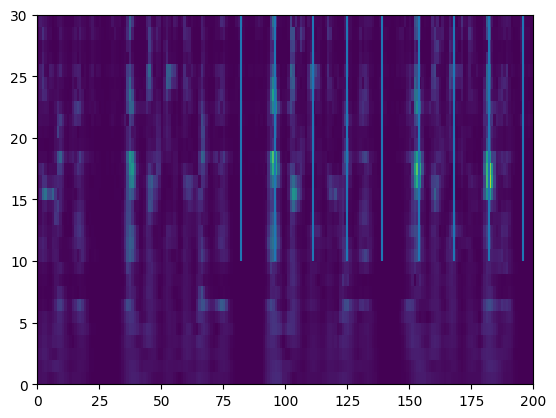

In [17]:
plt.pcolor(E_train.features['percussive'][0])
plt.vlines(E_train.features['beat'][0], 10, 30)
plt.xlim(0, 200)
plt.ylim(0, 30)

ChatGPT query

Write a python function with a following signature

```
rnd = np.random.default_rng(42)
def crop_by_beats(beat, harmony_specs, percussion_specs, frames_per_beat = 4, number_of_beats=16, number_of_samples=8)
    pass
```

beats is the integer array of frames at which there was a beat
upsample beats , for two neighboring values insert frames_per_beat-1 values between them uniformly cropped to the nearest frame

Next number_of_samples times sample starting position in the upsampled beats array and take number_of_beats * frames_per_beat consequent beats. Position must be sampled aligned to number_of_beats * frames_per_beat.

harmony_specs is a list of several spectrograms with harmonic parts of melody.
for each of harmony spec calculate the mean along time axis (axis = 1) between the consequent beats of the sample including the frames at which there was a beat

percussion_specs is a list of several spectrograms with percussion parts of melody. For each of percussion spec calculate the downsampled spectrogram as with harmony specs but shift the spectrogram so that the first sample was centered at the beat. The resulting length must be the same

return list of tuples containing downsampled spectrograms

In [18]:
rnd = np.random.default_rng(42)

def crop_by_beats(
    beat,
    harmony_specs,
    percussion_specs,
    frames_per_beat=4,
    number_of_beats=8,
    number_of_samples=8
):
    """
    Upsample the array of integer beat positions and then randomly extract 
    (number_of_samples) chunks of length (number_of_beats * frames_per_beat).
    
    For each chunk, compute the downsampled spectrogram:
      - For harmonic specs: take the mean along the time axis (axis=1) 
        between consecutive upsampled-beat boundaries.
      - For percussion specs: take the mean along the time axis over intervals 
        shifted so that each is centered at the corresponding upsampled beat.
    
    Parameters
    ----------
    beat : 1D array-like of int
        Array of frame indices at which a beat occurs. Must be strictly increasing.
    harmony_specs : list of np.ndarray
        Each element is a spectrogram for a harmonic component with shape 
        (freq_bins, time_frames).
    percussion_specs : list of np.ndarray
        Each element is a spectrogram for a percussion component with shape 
        (freq_bins, time_frames).
    frames_per_beat : int
        Number of subdivisions per original beat when upsampling.
    number_of_beats : int
        How many beats (in terms of upsampled subdivisions) to include in each chunk.
    number_of_samples : int
        How many random chunks to extract.
    
    Returns
    -------
    list of tuples
        A list (of length `number_of_samples`). Each element is:
        
            (harmony_downsampled_list, percussion_downsampled_list)
        
        where `harmony_downsampled_list` and `percussion_downsampled_list` are each 
        lists of spectrograms (in the same order as `harmony_specs` and 
        `percussion_specs`). Each downsampled spectrogram has shape:
        
            (freq_bins, number_of_beats * frames_per_beat)
    """
    
    # 1) Upsample 'beat' by inserting (frames_per_beat - 1) points 
    #    uniformly between each pair of consecutive beats.
    up_beats = []
    beat = np.array(beat, dtype=int)
    for i in range(len(beat) - 1):
        start = beat[i]
        end = beat[i + 1]
        diff = end - start
        
        # Insert frames_per_beat subdivisions between start and end, 
        # snapping to the nearest integer frame.
        for k in range(frames_per_beat):
            val = start + round(k * diff / frames_per_beat)
            # Avoid duplicates if rounding yields same as last appended
            if not up_beats or val != up_beats[-1]:
                up_beats.append(val)
    
    up_beats = np.array(up_beats, dtype=int)
    
    # 2) We need (number_of_beats * frames_per_beat + 1) upsampled-beat 
    #    positions for each chunk (the +1 is because we need the right boundary).
    needed_length = number_of_beats * frames_per_beat + 1
    total_upsampled = len(up_beats)
    
    # If we cannot extract even one chunk, return empty
    max_start = total_upsampled - needed_length
    if max_start < 0:
        return []
    
    # Possible start indices must be multiples of (4 * frames_per_beat)
    # so that each chunk is "aligned".
    stride = 4 * frames_per_beat
    possible_starts = np.arange(0, max_start + 1, stride)
    
    # Randomly choose 'number_of_samples' start indices from these possibilities
    chosen_starts = rnd.choice(possible_starts, size=number_of_samples, replace=True)
    
    results = []
    for start_idx in chosen_starts:
        # Boundaries for this sample
        boundary_points = up_beats[start_idx : start_idx + needed_length]
        # === 3) Downsample each harmony spec ===
        harmony_downsampled = []
        harmony_sampled = []
        for spec in harmony_specs:
            # spec has shape (freq_bins, time_frames)
            freq_bins = spec.shape[0]
            
            # We'll get (number_of_beats * frames_per_beat) intervals
            ds_harm = np.zeros((freq_bins, number_of_beats * frames_per_beat),
                               dtype=spec.dtype)
            for j in range(number_of_beats * frames_per_beat):
                left = boundary_points[j]
                right = boundary_points[j + 1]
                # Take the average along axis=1 (time axis)
                ds_harm[:, j] = spec[:, left:right].mean(axis=1)

            harmony_downsampled.append(ds_harm)
            harmony_sampled.append(spec[:,boundary_points[0]:boundary_points[-1]])
        
        # === 4) Downsample each percussion spec with centering ===
        percussion_downsampled = []
        percussion_sampled = []
        for spec in percussion_specs:
            
            freq_bins = spec.shape[0]
            ds_perc = np.zeros((freq_bins, number_of_beats * frames_per_beat),
                               dtype=spec.dtype)

            first_left = None
            old_right = None
            for j in range(number_of_beats * frames_per_beat):
                dist = boundary_points[j + 1] - boundary_points[j]
                right = boundary_points[j + 1] - dist // 2
                if old_right is None:
                    left = boundary_points[j] - dist // 2
                    if left < 0:
                        left = 0
                    first_left = left
                else:
                    left = old_right
                old_right = right

                # Average over the time axis in [left, right)
                chunk = spec[:, left:right]
                ds_perc[:, j] = chunk.mean(axis=1)

            percussion_downsampled.append(ds_perc)
            percussion_sampled.append(spec[:,first_left:old_right])
        
        # One result entry = (list_of_downsampled_harmony_specs, list_of_downsampled_percussion_specs)
        results.append((harmony_downsampled, percussion_downsampled, harmony_sampled, percussion_sampled))
    return results

In [19]:
Extractor.register_extractor('sample', 
                             lambda beat, cqt, harmonic, mfcc, percussive: 
                             crop_by_beats(
                                 beat=beat, 
                                 harmony_specs=[cqt, harmonic, mfcc], 
                                 percussion_specs=[percussive]
                             ), shuffle=True, map_labels=[
                                 ('idx', 's_idx'), 
                                 ('y', 's_y'), 
                                 ('stats', 's_stats'), 
                                 ('bpm', 's_bpm'),
                                 ('rms', 's_rms')
                             ])
Extractor.register_extractor('ds_cqt', lambda sample: sample[0][0])
Extractor.register_extractor('ds_harmonic', lambda sample: sample[0][1])
Extractor.register_extractor('ds_mfcc', lambda sample: sample[0][2])
Extractor.register_extractor('ds_percussive', lambda sample: sample[1][0])
Extractor.register_extractor('s_cqt', lambda sample: sample[2][0])
Extractor.register_extractor('s_harmonic', lambda sample: sample[2][1])
Extractor.register_extractor('s_mfcc', lambda sample: sample[2][2])
Extractor.register_extractor('s_percussive', lambda sample: sample[3][0])

In [20]:
E_train.soft_extract()
E_eval.soft_extract()

sample:   0%|          | 0/699 [00:00<?, ?it/s]

ds_cqt:   0%|          | 0/5592 [00:00<?, ?it/s]

ds_harmonic:   0%|          | 0/5592 [00:00<?, ?it/s]

ds_mfcc:   0%|          | 0/5592 [00:00<?, ?it/s]

ds_percussive:   0%|          | 0/5592 [00:00<?, ?it/s]

s_cqt:   0%|          | 0/5592 [00:00<?, ?it/s]

s_harmonic:   0%|          | 0/5592 [00:00<?, ?it/s]

s_mfcc:   0%|          | 0/5592 [00:00<?, ?it/s]

s_percussive:   0%|          | 0/5592 [00:00<?, ?it/s]

sample:   0%|          | 0/300 [00:00<?, ?it/s]

ds_cqt:   0%|          | 0/2400 [00:00<?, ?it/s]

ds_harmonic:   0%|          | 0/2400 [00:00<?, ?it/s]

ds_mfcc:   0%|          | 0/2400 [00:00<?, ?it/s]

ds_percussive:   0%|          | 0/2400 [00:00<?, ?it/s]

s_cqt:   0%|          | 0/2400 [00:00<?, ?it/s]

s_harmonic:   0%|          | 0/2400 [00:00<?, ?it/s]

s_mfcc:   0%|          | 0/2400 [00:00<?, ?it/s]

s_percussive:   0%|          | 0/2400 [00:00<?, ?it/s]

In [21]:
Extractor.register_extractor('cqt_per_freq_stats', 
                             lambda s_cqt: np.hstack([s_cqt.mean(axis=1), s_cqt.var(axis=1)]))
Extractor.register_extractor('harmonic_per_freq_stats', 
                             lambda s_harmonic: np.hstack([s_harmonic.mean(axis=1), s_harmonic.var(axis=1)]))
Extractor.register_extractor('percussive_per_freq_stats', 
                             lambda s_percussive: np.hstack([s_percussive.mean(axis=1), s_percussive.var(axis=1)]))
Extractor.register_extractor('percussive_beat_frames', 
                             lambda ds_percussive: ds_percussive.mean(axis=0))

In [22]:
E_train.soft_extract()
E_eval.soft_extract()

cqt_per_freq_stats:   0%|          | 0/5592 [00:00<?, ?it/s]

harmonic_per_freq_stats:   0%|          | 0/5592 [00:00<?, ?it/s]

percussive_per_freq_stats:   0%|          | 0/5592 [00:00<?, ?it/s]

percussive_beat_frames:   0%|          | 0/5592 [00:00<?, ?it/s]

cqt_per_freq_stats:   0%|          | 0/2400 [00:00<?, ?it/s]

harmonic_per_freq_stats:   0%|          | 0/2400 [00:00<?, ?it/s]

percussive_per_freq_stats:   0%|          | 0/2400 [00:00<?, ?it/s]

percussive_beat_frames:   0%|          | 0/2400 [00:00<?, ?it/s]

In [23]:
features = ['cqt_per_freq_stats', 'harmonic_per_freq_stats', 'percussive_per_freq_stats', 'percussive_beat_frames']
model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['s_idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['s_y'])[:,0], 
    y_eval=E_eval.get_features(['s_y'])[:,0]
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2945279	test: 0.2991667	best: 0.2991667 (0)	total: 70.2ms	remaining: 35s
50:	learn: 0.6471745	test: 0.5579167	best: 0.5604167 (46)	total: 1.63s	remaining: 14.3s
100:	learn: 0.7446352	test: 0.6025000	best: 0.6087500 (96)	total: 3.03s	remaining: 12s
150:	learn: 0.8068670	test: 0.6304167	best: 0.6308333 (148)	total: 4.35s	remaining: 10.1s
200:	learn: 0.8513948	test: 0.6562500	best: 0.6562500 (199)	total: 6.09s	remaining: 9.07s
250:	learn: 0.8769671	test: 0.6625000	best: 0.6654167 (230)	total: 7.77s	remaining: 7.71s
300:	learn: 0.8986052	test: 0.6725000	best: 0.6758333 (293)	total: 9.4s	remaining: 6.22s
350:	learn: 0.9155937	test: 0.6833333	best: 0.6837500 (348)	total: 11.2s	remaining: 4.76s
400:	learn: 0.9298999	test: 0.6779167	best: 0.6841667 (360)	total: 12.9s	remaining: 3.19s
450:	learn: 0.9397353	test: 0.6829167	best: 0.6841667 (360)	total: 14.3s	remaining: 1.55s
499:	learn: 0.9481402	test: 0.6887500	best: 0.6887500 (483)	total: 15.6s	remaining: 0us

bestTest = 0.68875
bes

In [24]:
pd.DataFrame(
    data=model.feature_importances_, 
    index=E_train.get_feature_names_vector(features), 
    columns=['importance']
).sort_values(by='importance', ascending=False).head(15)

,importance
percussive_per_freq_stats_13,1.860962
percussive_per_freq_stats_102,1.800169
percussive_per_freq_stats_100,1.713587
percussive_per_freq_stats_92,1.485996
percussive_per_freq_stats_24,1.332584
percussive_per_freq_stats_16,1.081001
cqt_per_freq_stats_100,1.058225
percussive_per_freq_stats_111,1.001478
harmonic_per_freq_stats_80,0.989797
percussive_per_freq_stats_94,0.945060


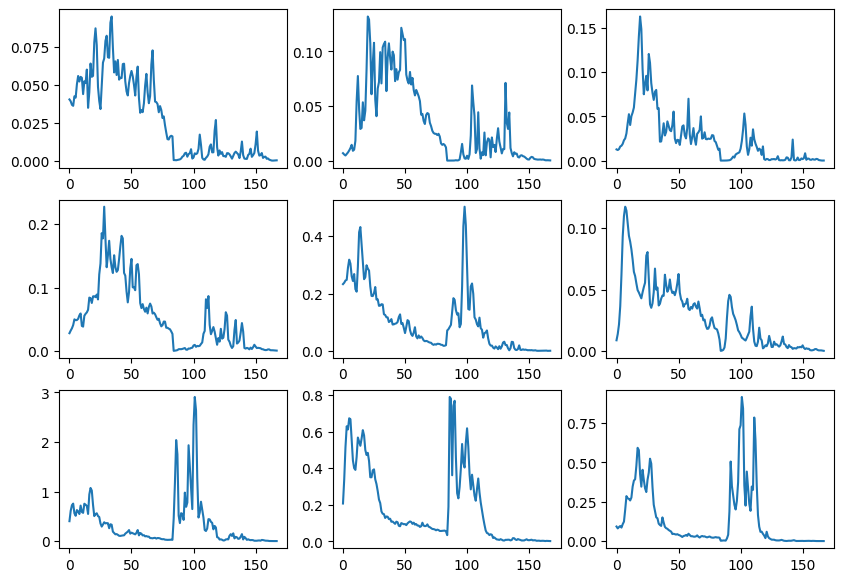

In [25]:
# It looks like the one of the most important features are high frequencies of drums, which is the last thing I expected. Lets check pictures:
s_y = E_train.get_features(['s_y'])[:, 0]
jazz_idx = np.where(s_y == 'jazz')[0][:3]
rock_idx = np.where(s_y == 'rock')[0][:3]
hip_hop_idx = np.where(s_y == 'hiphop')[0][:3]

plt.figure().set_size_inches(10, 7)
for pos, idx in enumerate(np.hstack([jazz_idx, rock_idx, hip_hop_idx])):
    plt.subplot(3, 3, pos + 1)
    plt.plot(E_train.features['percussive_per_freq_stats'][idx])

In [26]:
# Lets add BPM and RMS

features = ['s_rms', 's_bpm', 'cqt_per_freq_stats', 'harmonic_per_freq_stats', 'percussive_per_freq_stats', 'percussive_beat_frames']
model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['s_idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['s_y'])[:,0], 
    y_eval=E_eval.get_features(['s_y'])[:,0]
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3041845	test: 0.2945833	best: 0.2945833 (0)	total: 83.4ms	remaining: 41.6s
50:	learn: 0.6491416	test: 0.5650000	best: 0.5650000 (50)	total: 1.79s	remaining: 15.8s
100:	learn: 0.7548283	test: 0.6270833	best: 0.6283333 (99)	total: 3.33s	remaining: 13.2s
150:	learn: 0.8215308	test: 0.6466667	best: 0.6466667 (150)	total: 4.68s	remaining: 10.8s
200:	learn: 0.8524678	test: 0.6583333	best: 0.6591667 (199)	total: 6s	remaining: 8.92s
250:	learn: 0.8864449	test: 0.6708333	best: 0.6725000 (226)	total: 7.59s	remaining: 7.53s
300:	learn: 0.9086195	test: 0.6754167	best: 0.6766667 (291)	total: 9.23s	remaining: 6.1s
350:	learn: 0.9257868	test: 0.6795833	best: 0.6800000 (336)	total: 10.6s	remaining: 4.5s
400:	learn: 0.9406295	test: 0.6883333	best: 0.6883333 (400)	total: 12s	remaining: 2.96s
450:	learn: 0.9502861	test: 0.6883333	best: 0.6891667 (408)	total: 13.4s	remaining: 1.46s
499:	learn: 0.9565451	test: 0.6879167	best: 0.6904167 (481)	total: 15.1s	remaining: 0us

bestTest = 0.6904166667


In [27]:
pd.DataFrame(
    data=model.feature_importances_, 
    index=E_train.get_feature_names_vector(features), 
    columns=['importance']
).sort_values(by='importance', ascending=False).head(15)

,importance
s_bpm_0,2.990165
s_rms_0,2.505802
percussive_per_freq_stats_103,2.240952
percussive_per_freq_stats_92,1.544422
percussive_per_freq_stats_101,1.532344
percussive_per_freq_stats_111,1.435889
percussive_per_freq_stats_100,1.206888
percussive_per_freq_stats_95,1.165411
percussive_per_freq_stats_91,1.020118
harmonic_per_freq_stats_80,1.013218


Common to all splits features look more important to catboost (as they contain data about whole sample).
But we will calculate majority over samples, and using common features sploils the whole bagging idea.
Luckily it is possible to specify feature weights in catboost

In [28]:
# ChatGPT query:
#
# I have an array with feature names and I want to generate weights for the features. Some of the feature names look like <name>_<index>. 
# I want to make a function receiving a dict with prefixes and corresponding feature weights. 
# It should return the np.array of the same shape as feature_names, containing weights. 
# If the feature name starts with prefix from the dict then the weight has to be taken from the dict, otherwise it has to be 1. 
# Here is the signature:
# 
# def assign_feature_weights(feature_names: np.ndarray, weights: dict[str, int]) -> np.ndarray:
#     pass

import numpy as np

def assign_feature_weights(feature_names: np.ndarray, weights: dict[str, float]) -> np.ndarray:
    """
    Assign weights to features based on given prefixes.
    
    Parameters
    ----------
    feature_names : np.ndarray
        Array of feature names.
    weights : dict[str, float]
        Dictionary mapping a prefix (string) to a weight (float).
        
    Returns
    -------
    np.ndarray
        An array of the same shape as `feature_names` containing the assigned weights. 
        If a feature name starts with any prefix in `weights`, the corresponding weight 
        is used. Otherwise, the weight is 1.0.
    """
    result_weights = np.ones_like(feature_names, dtype=float)  # default is 1.0
    
    for i, fname in enumerate(feature_names):
        for prefix, w in weights.items():
            if fname.startswith(prefix):
                result_weights[i] = w
                break  # Stop at the first matching prefix

    return result_weights


In [29]:
features = ['s_rms', 's_bpm', 'cqt_per_freq_stats', 'harmonic_per_freq_stats', 'percussive_per_freq_stats', 'percussive_beat_frames']
weights = assign_feature_weights(E_train.get_feature_names_vector(features), dict(s_rms=0.7, s_bpm=0.7))
model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['s_idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['s_y'])[:,0], 
    y_eval=E_eval.get_features(['s_y'])[:,0],
    feature_weights=weights
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3041845	test: 0.2945833	best: 0.2945833 (0)	total: 78.1ms	remaining: 39s
50:	learn: 0.6600501	test: 0.5620833	best: 0.5620833 (50)	total: 1.5s	remaining: 13.2s
100:	learn: 0.7585837	test: 0.6237500	best: 0.6245833 (97)	total: 2.88s	remaining: 11.4s
150:	learn: 0.8097282	test: 0.6466667	best: 0.6483333 (138)	total: 4.47s	remaining: 10.3s
200:	learn: 0.8530043	test: 0.6587500	best: 0.6604167 (175)	total: 6.1s	remaining: 9.08s
250:	learn: 0.8798283	test: 0.6700000	best: 0.6700000 (250)	total: 7.56s	remaining: 7.5s
300:	learn: 0.8996781	test: 0.6791667	best: 0.6795833 (294)	total: 8.9s	remaining: 5.88s
350:	learn: 0.9198856	test: 0.6729167	best: 0.6795833 (294)	total: 10.3s	remaining: 4.38s
400:	learn: 0.9334764	test: 0.6829167	best: 0.6887500 (386)	total: 12s	remaining: 2.95s
450:	learn: 0.9433119	test: 0.6866667	best: 0.6887500 (386)	total: 13.6s	remaining: 1.47s
499:	learn: 0.9527897	test: 0.6845833	best: 0.6895833 (460)	total: 14.9s	remaining: 0us

bestTest = 0.6895833333
b

In [30]:
pd.DataFrame(
    data=model.feature_importances_, 
    index=E_train.get_feature_names_vector(features), 
    columns=['importance']
).sort_values(by='importance', ascending=False).head(15)

,importance
percussive_per_freq_stats_103,2.251306
percussive_per_freq_stats_101,1.633343
percussive_per_freq_stats_111,1.352486
percussive_per_freq_stats_95,1.307608
percussive_per_freq_stats_92,1.283767
s_bpm_0,1.187593
percussive_per_freq_stats_91,1.154281
harmonic_per_freq_stats_80,1.131064
percussive_per_freq_stats_100,1.087781
percussive_per_freq_stats_108,1.046582


In [31]:
# Lets add other stats

features = ['s_stats', 's_bpm', 'cqt_per_freq_stats', 'harmonic_per_freq_stats', 'percussive_per_freq_stats', 'percussive_beat_frames']
weights = assign_feature_weights(E_train.get_feature_names_vector(features), dict(s_bpm=0.7, s_stats=0.68))

model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['s_idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['s_y'])[:,0], 
    y_eval=E_eval.get_features(['s_y'])[:,0],
    feature_weights=weights
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3034692	test: 0.3091667	best: 0.3091667 (0)	total: 86.4ms	remaining: 43.1s
50:	learn: 0.7616237	test: 0.6487500	best: 0.6508333 (48)	total: 1.67s	remaining: 14.7s
100:	learn: 0.8546137	test: 0.7229167	best: 0.7245833 (96)	total: 3.5s	remaining: 13.8s
150:	learn: 0.9141631	test: 0.7612500	best: 0.7612500 (150)	total: 5.16s	remaining: 11.9s
200:	learn: 0.9493920	test: 0.7850000	best: 0.7850000 (200)	total: 6.67s	remaining: 9.92s
250:	learn: 0.9638770	test: 0.7887500	best: 0.7916667 (239)	total: 8.13s	remaining: 8.06s
300:	learn: 0.9760372	test: 0.7937500	best: 0.7966667 (286)	total: 9.83s	remaining: 6.5s
350:	learn: 0.9821173	test: 0.7995833	best: 0.8008333 (348)	total: 11.6s	remaining: 4.93s
400:	learn: 0.9890916	test: 0.7991667	best: 0.8008333 (348)	total: 13.1s	remaining: 3.24s
450:	learn: 0.9917740	test: 0.8000000	best: 0.8029167 (440)	total: 14.6s	remaining: 1.59s
499:	learn: 0.9949928	test: 0.8054167	best: 0.8062500 (495)	total: 16.2s	remaining: 0us

bestTest = 0.80625


In [32]:
imp = pd.DataFrame(
    data=model.feature_importances_, 
    index=E_train.get_feature_names_vector(features), 
    columns=['importance']
).sort_values(by='importance', ascending=False).head(15)
imp['stat_name'] = pd.Series(imp.index, index=imp.index).apply(lambda x: int(x[8:]) if x.startswith('s_stats') else None)
imp['stat_name'] = imp['stat_name'].apply(lambda x: X_train.columns[int(x) + 2] if not np.isnan(x) else None)
imp

,importance,stat_name
s_stats_26,3.797915,mfcc5_var
s_stats_23,3.227812,mfcc4_mean
s_stats_27,2.672782,mfcc6_mean
s_stats_0,2.300775,chroma_stft_mean
percussive_per_freq_stats_103,2.115719,None
s_stats_24,2.076114,mfcc4_var
s_stats_12,1.866515,harmony_mean
s_stats_5,1.806029,spectral_centroid_var
s_stats_1,1.800582,chroma_stft_var
percussive_per_freq_stats_9,1.600120,None


TODO: translate to English
1. Высокий вес у mfcc - это преобразование Фурье посчитанное поверх mel спектрограммы.
Эта операция выполняет 2 цели, понижает размерность, и позволяет оценить фундаментальную частоту
2. Высокий вес у статистик над хроматическими фичами (то есть какая нота встречается чаще)
3. Высокий вес у статистик спектрального центроида

Вывод: Надо добавить эти фичи, только посчитанные на кусочке

In [33]:
Extractor.register_extractor('mfcc_quef_stats', 
                             lambda s_mfcc: np.hstack([s_mfcc.mean(axis=1), s_mfcc.var(axis=1)]))

# Usually STFT is used for spectral centroid, but I will use CQT, it may turn out to be even more precise.
cqt_frequencies = librosa.cqt_frequencies(n_bins=n_bins, fmin=fmin, bins_per_octave=bins_per_octave)
Extractor.register_extractor('cqt_spectral_centroid', 
                             lambda s_cqt: np.sum(cqt_frequencies.reshape(-1, 1) * librosa.util.normalize(s_cqt, norm=1, axis=-2), axis=0))

Extractor.register_extractor('cqt_spectral_centroid_stats', 
                             lambda cqt_spectral_centroid: np.array([cqt_spectral_centroid.mean(), cqt_spectral_centroid.var()]))

chroma_map = librosa.filters.cq_to_chroma(cqt_frequencies.shape[0], bins_per_octave=bins_per_octave, n_chroma=bins_per_octave, fmin=fmin)
Extractor.register_extractor('cqt_chroma', 
                             lambda s_cqt: np.dot(chroma_map, s_cqt))
Extractor.register_extractor('cqt_chroma_stats', 
                             lambda cqt_chroma: np.hstack([cqt_chroma.mean(axis=1), cqt_chroma.var(axis=1)]))

Extractor.register_extractor('harmonic_chroma', 
                             lambda s_harmonic: np.dot(chroma_map, s_harmonic))
Extractor.register_extractor('harmonic_chroma_stats', 
                             lambda harmonic_chroma: np.hstack([harmonic_chroma.mean(axis=1), harmonic_chroma.var(axis=1)]))


In [34]:
E_train.soft_extract()
E_eval.soft_extract()

mfcc_quef_stats:   0%|          | 0/5592 [00:00<?, ?it/s]

cqt_spectral_centroid:   0%|          | 0/5592 [00:00<?, ?it/s]

cqt_spectral_centroid_stats:   0%|          | 0/5592 [00:00<?, ?it/s]

cqt_chroma:   0%|          | 0/5592 [00:00<?, ?it/s]

cqt_chroma_stats:   0%|          | 0/5592 [00:00<?, ?it/s]

harmonic_chroma:   0%|          | 0/5592 [00:00<?, ?it/s]

harmonic_chroma_stats:   0%|          | 0/5592 [00:00<?, ?it/s]

mfcc_quef_stats:   0%|          | 0/2400 [00:00<?, ?it/s]

cqt_spectral_centroid:   0%|          | 0/2400 [00:00<?, ?it/s]

cqt_spectral_centroid_stats:   0%|          | 0/2400 [00:00<?, ?it/s]

cqt_chroma:   0%|          | 0/2400 [00:00<?, ?it/s]

cqt_chroma_stats:   0%|          | 0/2400 [00:00<?, ?it/s]

harmonic_chroma:   0%|          | 0/2400 [00:00<?, ?it/s]

harmonic_chroma_stats:   0%|          | 0/2400 [00:00<?, ?it/s]

In [35]:
# Lets add MFCC, chromatic features and centroid

features = ['s_rms', 's_bpm', 'cqt_per_freq_stats', 'harmonic_per_freq_stats', 'percussive_per_freq_stats', 'percussive_beat_frames',
           'cqt_spectral_centroid_stats', 'cqt_chroma_stats', 'harmonic_chroma_stats', 'mfcc_quef_stats']
weights = assign_feature_weights(E_train.get_feature_names_vector(features), dict(s_rms=0.5, s_bpm=0.7, mfcc_quef=0.8))
model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['s_idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['s_y'])[:,0], 
    y_eval=E_eval.get_features(['s_y'])[:,0],
    feature_weights=weights
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2973891	test: 0.2758333	best: 0.2758333 (0)	total: 93.6ms	remaining: 46.7s
50:	learn: 0.6695279	test: 0.5804167	best: 0.5854167 (49)	total: 1.71s	remaining: 15s
100:	learn: 0.7619814	test: 0.6325000	best: 0.6358333 (99)	total: 3.66s	remaining: 14.5s
150:	learn: 0.8227825	test: 0.6687500	best: 0.6687500 (150)	total: 5.44s	remaining: 12.6s
200:	learn: 0.8637339	test: 0.6862500	best: 0.6862500 (197)	total: 6.92s	remaining: 10.3s
250:	learn: 0.8916309	test: 0.6937500	best: 0.6950000 (241)	total: 8.59s	remaining: 8.52s
300:	learn: 0.9132690	test: 0.6958333	best: 0.6987500 (276)	total: 10.1s	remaining: 6.66s
350:	learn: 0.9293634	test: 0.6991667	best: 0.7020833 (333)	total: 11.6s	remaining: 4.94s
400:	learn: 0.9409871	test: 0.7029167	best: 0.7079167 (379)	total: 13.1s	remaining: 3.25s
450:	learn: 0.9506438	test: 0.7108333	best: 0.7137500 (444)	total: 14.6s	remaining: 1.59s
499:	learn: 0.9585122	test: 0.7100000	best: 0.7145833 (485)	total: 16.1s	remaining: 0us

bestTest = 0.714583

In [36]:
pd.DataFrame(
    data=model.feature_importances_, 
    index=E_train.get_feature_names_vector(features), 
    columns=['importance']
).sort_values(by='importance', ascending=False).head(15)

,importance
mfcc_quef_stats_17,2.555800
percussive_per_freq_stats_102,2.100362
mfcc_quef_stats_3,1.653333
cqt_spectral_centroid_stats_1,1.352556
s_bpm_0,1.324758
mfcc_quef_stats_16,1.203805
percussive_per_freq_stats_109,1.188045
percussive_per_freq_stats_91,1.182254
percussive_per_freq_stats_12,1.115728
percussive_per_freq_stats_112,1.047367


In [37]:
# Lets leave out only features that turn out important. Boosting is not robust to autocorrelation. 
# There is of course a penalty in CatBoost, but still it makes sense.
imp = pd.DataFrame(data=np.stack([E_train.get_feature_names_vector(features)]).T, columns=['feature_name'])
imp['importance'] = model.feature_importances_
imp['cropped_feature_name'] = imp['feature_name'].apply(lambda x: '_'.join(x.split('_')[:-1]))
imp[['cropped_feature_name', 'importance']].groupby('cropped_feature_name').agg(['max', 'mean']).sort_values(('importance', 'max'), ascending=False)

importance          
                                   max      mean
cropped_feature_name                            
mfcc_quef_stats               2.555800  0.470026
percussive_per_freq_stats     2.100362  0.168522
cqt_spectral_centroid_stats   1.352556  0.923675
s_bpm                         1.324758  1.324758
harmonic_per_freq_stats       0.975192  0.188518
cqt_per_freq_stats            0.801020  0.097102
percussive_beat_frames        0.727212  0.168800
cqt_chroma_stats              0.374091  0.061525
harmonic_chroma_stats         0.217795  0.059716
s_rms                         0.000000  0.000000

In [38]:
features = ['s_bpm', 'harmonic_per_freq_stats', 'percussive_per_freq_stats',
           'cqt_spectral_centroid_stats', 'mfcc_quef_stats', 'percussive_beat_frames']
weights = assign_feature_weights(E_train.get_feature_names_vector(features), dict(s_rms=0.5, s_bpm=0.7, mfcc_quef=0.8))
model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['s_idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['s_y'])[:,0], 
    y_eval=E_eval.get_features(['s_y'])[:,0],
    feature_weights=weights
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2963162	test: 0.2862500	best: 0.2862500 (0)	total: 30.3ms	remaining: 15.1s
50:	learn: 0.6793634	test: 0.5895833	best: 0.5895833 (50)	total: 1.13s	remaining: 9.97s
100:	learn: 0.7744993	test: 0.6412500	best: 0.6450000 (95)	total: 2.17s	remaining: 8.55s
150:	learn: 0.8261803	test: 0.6704167	best: 0.6758333 (145)	total: 3.2s	remaining: 7.39s
200:	learn: 0.8690987	test: 0.6825000	best: 0.6837500 (185)	total: 4.23s	remaining: 6.29s
250:	learn: 0.8964592	test: 0.6983333	best: 0.6987500 (232)	total: 5.25s	remaining: 5.2s
300:	learn: 0.9095136	test: 0.7075000	best: 0.7083333 (288)	total: 6.26s	remaining: 4.14s
350:	learn: 0.9265021	test: 0.7137500	best: 0.7175000 (337)	total: 7.3s	remaining: 3.1s
400:	learn: 0.9358011	test: 0.7191667	best: 0.7208333 (396)	total: 8.3s	remaining: 2.05s
450:	learn: 0.9472461	test: 0.7229167	best: 0.7229167 (449)	total: 9.29s	remaining: 1.01s
499:	learn: 0.9558298	test: 0.7195833	best: 0.7279167 (485)	total: 10.2s	remaining: 0us

bestTest = 0.727916666

Lets try normalizing spectrograms. That way we will consider loundness and distribution separately

In [39]:
Extractor.register_extractor('s_cqt_n', lambda s_cqt: librosa.util.normalize(s_cqt, norm=1))
Extractor.register_extractor('s_cqt_stats', lambda s_cqt: np.array([np.mean(s_cqt), np.var(s_cqt)]))
Extractor.register_extractor('s_harmonic_n', lambda s_harmonic: librosa.util.normalize(s_harmonic, norm=1))
Extractor.register_extractor('s_harmonic_stats', lambda s_harmonic: np.array([np.mean(s_harmonic), np.var(s_harmonic)]))
Extractor.register_extractor('s_percussive_n', lambda s_percussive: librosa.util.normalize(s_percussive, norm=1))
Extractor.register_extractor('s_percussive_stats', lambda s_percussive: np.array([np.mean(s_percussive), np.var(s_percussive)]))
Extractor.register_extractor('ds_percussive_n', lambda ds_percussive: librosa.util.normalize(ds_percussive, norm=1))

Extractor.register_extractor('cqt_n_freq_stats', 
                             lambda s_cqt_n: np.hstack([s_cqt_n.mean(axis=1), s_cqt_n.var(axis=1)]))
Extractor.register_extractor('harmonic_n_freq_stats', 
                             lambda s_harmonic_n: np.hstack([s_harmonic_n.mean(axis=1), s_harmonic_n.var(axis=1)]))
Extractor.register_extractor('percussive_n_freq_stats', 
                             lambda s_percussive_n: np.hstack([s_percussive_n.mean(axis=1), s_percussive_n.var(axis=1)]))
Extractor.register_extractor('percussive_n_beat_frames', 
                             lambda ds_percussive_n: ds_percussive_n.mean(axis=0))

In [40]:
E_train.soft_extract()
E_eval.soft_extract()

s_cqt_n:   0%|          | 0/5592 [00:00<?, ?it/s]

s_cqt_stats:   0%|          | 0/5592 [00:00<?, ?it/s]

s_harmonic_n:   0%|          | 0/5592 [00:00<?, ?it/s]

s_harmonic_stats:   0%|          | 0/5592 [00:00<?, ?it/s]

s_percussive_n:   0%|          | 0/5592 [00:00<?, ?it/s]

s_percussive_stats:   0%|          | 0/5592 [00:00<?, ?it/s]

ds_percussive_n:   0%|          | 0/5592 [00:00<?, ?it/s]

cqt_n_freq_stats:   0%|          | 0/5592 [00:00<?, ?it/s]

harmonic_n_freq_stats:   0%|          | 0/5592 [00:00<?, ?it/s]

percussive_n_freq_stats:   0%|          | 0/5592 [00:00<?, ?it/s]

percussive_n_beat_frames:   0%|          | 0/5592 [00:00<?, ?it/s]

s_cqt_n:   0%|          | 0/2400 [00:00<?, ?it/s]

s_cqt_stats:   0%|          | 0/2400 [00:00<?, ?it/s]

s_harmonic_n:   0%|          | 0/2400 [00:00<?, ?it/s]

s_harmonic_stats:   0%|          | 0/2400 [00:00<?, ?it/s]

s_percussive_n:   0%|          | 0/2400 [00:00<?, ?it/s]

s_percussive_stats:   0%|          | 0/2400 [00:00<?, ?it/s]

ds_percussive_n:   0%|          | 0/2400 [00:00<?, ?it/s]

cqt_n_freq_stats:   0%|          | 0/2400 [00:00<?, ?it/s]

harmonic_n_freq_stats:   0%|          | 0/2400 [00:00<?, ?it/s]

percussive_n_freq_stats:   0%|          | 0/2400 [00:00<?, ?it/s]

percussive_n_beat_frames:   0%|          | 0/2400 [00:00<?, ?it/s]

In [41]:
features = ['s_bpm', 'cqt_n_freq_stats', 's_cqt_stats', 'harmonic_n_freq_stats', 's_harmonic_stats', 'percussive_n_freq_stats', 's_percussive_stats',
           'cqt_spectral_centroid_stats', 'mfcc_quef_stats', 'percussive_n_beat_frames']
weights = assign_feature_weights(E_train.get_feature_names_vector(features), dict(s_cqt_stats=0.7, s_harmonic_stats=0.6, s_percussive_stats=0.6, s_rms=0.4, s_bpm=0.7, mfcc_quef=0.8))
model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['s_idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['s_y'])[:,0], 
    y_eval=E_eval.get_features(['s_y'])[:,0],
    feature_weights=weights
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2371245	test: 0.2304167	best: 0.2304167 (0)	total: 98ms	remaining: 48.9s
50:	learn: 0.6777539	test: 0.5916667	best: 0.5916667 (49)	total: 1.54s	remaining: 13.6s
100:	learn: 0.7746781	test: 0.6162500	best: 0.6241667 (95)	total: 2.87s	remaining: 11.3s
150:	learn: 0.8251073	test: 0.6508333	best: 0.6512500 (149)	total: 4.53s	remaining: 10.5s
200:	learn: 0.8640916	test: 0.6583333	best: 0.6625000 (195)	total: 5.87s	remaining: 8.73s
250:	learn: 0.8880544	test: 0.6625000	best: 0.6679167 (214)	total: 7.18s	remaining: 7.13s
300:	learn: 0.9109442	test: 0.6658333	best: 0.6683333 (267)	total: 8.46s	remaining: 5.6s
350:	learn: 0.9282904	test: 0.6791667	best: 0.6791667 (350)	total: 9.76s	remaining: 4.14s
400:	learn: 0.9375894	test: 0.6770833	best: 0.6825000 (358)	total: 11.1s	remaining: 2.74s
450:	learn: 0.9495708	test: 0.6879167	best: 0.6879167 (428)	total: 12.4s	remaining: 1.35s
499:	learn: 0.9563662	test: 0.6858333	best: 0.6879167 (428)	total: 13.8s	remaining: 0us

bestTest = 0.6879166

In [42]:
pd.DataFrame(
    data=model.feature_importances_, 
    index=E_train.get_feature_names_vector(features), 
    columns=['importance']
).sort_values(by='importance', ascending=False).head(15)

,importance
s_percussive_stats_1,3.542872
mfcc_quef_stats_0,2.933706
mfcc_quef_stats_18,1.908849
mfcc_quef_stats_17,1.903218
percussive_n_freq_stats_103,1.741569
harmonic_n_freq_stats_7,1.741066
s_cqt_stats_1,1.737402
percussive_n_freq_stats_96,1.708620
cqt_n_freq_stats_93,1.589942
mfcc_quef_stats_16,1.525116


In [43]:
features = ['s_stats', 's_bpm', 'cqt_per_freq_stats', 'harmonic_per_freq_stats', 'percussive_per_freq_stats',
           'cqt_spectral_centroid_stats', 'mfcc_quef_stats', 'percussive_beat_frames']
weights = assign_feature_weights(E_train.get_feature_names_vector(features), dict(s_stats=0.6, s_rms=0.5, s_bpm=0.7, mfcc_quef=0.8))
model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['s_idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['s_y'])[:,0], 
    y_eval=E_eval.get_features(['s_y'])[:,0],
    feature_weights=weights
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3118741	test: 0.3070833	best: 0.3070833 (0)	total: 117ms	remaining: 58.2s
50:	learn: 0.7407010	test: 0.6329167	best: 0.6329167 (50)	total: 1.73s	remaining: 15.2s
100:	learn: 0.8354793	test: 0.7070833	best: 0.7083333 (99)	total: 3.32s	remaining: 13.1s
150:	learn: 0.9023605	test: 0.7300000	best: 0.7300000 (150)	total: 4.82s	remaining: 11.1s
200:	learn: 0.9293634	test: 0.7491667	best: 0.7504167 (198)	total: 6.3s	remaining: 9.38s
250:	learn: 0.9526109	test: 0.7629167	best: 0.7633333 (249)	total: 7.82s	remaining: 7.76s
300:	learn: 0.9662017	test: 0.7708333	best: 0.7725000 (298)	total: 9.36s	remaining: 6.19s
350:	learn: 0.9760372	test: 0.7779167	best: 0.7800000 (337)	total: 10.9s	remaining: 4.61s
400:	learn: 0.9808655	test: 0.7808333	best: 0.7812500 (358)	total: 12.4s	remaining: 3.05s
450:	learn: 0.9867668	test: 0.7845833	best: 0.7866667 (435)	total: 14s	remaining: 1.52s
499:	learn: 0.9892704	test: 0.7866667	best: 0.7891667 (488)	total: 15.5s	remaining: 0us

bestTest = 0.78916666

In [44]:
imp = pd.DataFrame(
    data=model.feature_importances_, 
    index=E_train.get_feature_names_vector(features), 
    columns=['importance']
).sort_values(by='importance', ascending=False).head(15)
imp['stat_name'] = pd.Series(imp.index, index=imp.index).apply(lambda x: int(x[8:]) if x.startswith('s_stats') else None)
imp['stat_name'] = imp['stat_name'].apply(lambda x: X_train.columns[int(x) + 2] if not np.isnan(x) else None)
imp

,importance,stat_name
s_stats_26,3.110332,mfcc5_var
s_stats_0,2.400861,chroma_stft_mean
s_stats_23,2.348540,mfcc4_mean
s_stats_33,1.544775,mfcc9_mean
percussive_per_freq_stats_100,1.496329,None
s_stats_12,1.389909,harmony_mean
s_stats_5,1.358316,spectral_centroid_var
s_stats_27,1.341501,mfcc6_mean
percussive_per_freq_stats_15,1.215955,None
percussive_per_freq_stats_19,1.213377,None


In [45]:
Extractor.register_extractor('cqt_chroma_1d_stats', lambda cqt_chroma: np.array([np.mean(cqt_chroma), np.var(cqt_chroma)]))
Extractor.register_extractor('harmonic_chroma_1d_stats', lambda harmonic_chroma: np.array([np.mean(harmonic_chroma), np.var(harmonic_chroma)]))

In [46]:
E_train.soft_extract()
E_eval.soft_extract()

cqt_chroma_1d_stats:   0%|          | 0/5592 [00:00<?, ?it/s]

harmonic_chroma_1d_stats:   0%|          | 0/5592 [00:00<?, ?it/s]

cqt_chroma_1d_stats:   0%|          | 0/2400 [00:00<?, ?it/s]

harmonic_chroma_1d_stats:   0%|          | 0/2400 [00:00<?, ?it/s]

In [47]:
features = ['s_bpm', 'cqt_per_freq_stats', 'harmonic_per_freq_stats', 'percussive_per_freq_stats',
           'cqt_spectral_centroid_stats', 'mfcc_quef_stats', 'percussive_beat_frames', 'cqt_chroma_1d_stats', 'harmonic_chroma_1d_stats']
weights = assign_feature_weights(E_train.get_feature_names_vector(features), dict(s_rms=0.5, s_bpm=0.7, mfcc_quef=0.8))
model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['s_idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['s_y'])[:,0], 
    y_eval=E_eval.get_features(['s_y'])[:,0],
    feature_weights=weights
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3218884	test: 0.2979167	best: 0.2979167 (0)	total: 94.9ms	remaining: 47.4s
50:	learn: 0.6734621	test: 0.5708333	best: 0.5708333 (50)	total: 1.93s	remaining: 17s
100:	learn: 0.7696710	test: 0.6383333	best: 0.6383333 (100)	total: 3.42s	remaining: 13.5s
150:	learn: 0.8295780	test: 0.6579167	best: 0.6591667 (146)	total: 4.86s	remaining: 11.2s
200:	learn: 0.8658798	test: 0.6766667	best: 0.6804167 (190)	total: 6.66s	remaining: 9.91s
250:	learn: 0.8964592	test: 0.6895833	best: 0.6895833 (249)	total: 8.37s	remaining: 8.31s
300:	learn: 0.9186338	test: 0.6908333	best: 0.6937500 (287)	total: 9.79s	remaining: 6.48s
350:	learn: 0.9320458	test: 0.6966667	best: 0.6983333 (329)	total: 11.2s	remaining: 4.75s
400:	learn: 0.9406295	test: 0.7079167	best: 0.7087500 (387)	total: 12.7s	remaining: 3.13s
450:	learn: 0.9495708	test: 0.7108333	best: 0.7108333 (450)	total: 14.4s	remaining: 1.56s
499:	learn: 0.9581545	test: 0.7120833	best: 0.7145833 (472)	total: 15.9s	remaining: 0us

bestTest = 0.71458

In [48]:
pd.DataFrame(
    data=model.feature_importances_, 
    index=E_train.get_feature_names_vector(features), 
    columns=['importance']
).sort_values(by='importance', ascending=False).head(15)

,importance
percussive_per_freq_stats_13,1.865174
mfcc_quef_stats_16,1.658949
percussive_per_freq_stats_18,1.545962
mfcc_quef_stats_3,1.503084
percussive_per_freq_stats_25,1.471228
mfcc_quef_stats_17,1.376585
mfcc_quef_stats_15,1.280125
percussive_per_freq_stats_112,1.243802
percussive_per_freq_stats_93,1.221018
cqt_spectral_centroid_stats_1,1.175296


In [49]:
roll_percent = 0.85
Extractor.register_extractor('cqt_rollof', 
                             lambda s_cqt: librosa.feature.spectral.spectral_rolloff(S=s_cqt, freq=cqt_frequencies, roll_percent=roll_percent))

Extractor.register_extractor('cqt_rollof_stats', 
                             lambda cqt_rollof: np.array([cqt_rollof.mean(), cqt_rollof.var()]))

Extractor.register_extractor('cqt_bandwidth', 
                             lambda s_cqt: librosa.feature.spectral.spectral_bandwidth(S=s_cqt, freq=cqt_frequencies))

Extractor.register_extractor('cqt_bandwidth_stats', 
                             lambda cqt_bandwidth: np.array([cqt_bandwidth.mean(), cqt_bandwidth.var()]))



In [50]:
E_train.soft_extract()
E_eval.soft_extract()

cqt_rollof:   0%|          | 0/5592 [00:00<?, ?it/s]

cqt_rollof_stats:   0%|          | 0/5592 [00:00<?, ?it/s]

cqt_bandwidth:   0%|          | 0/5592 [00:00<?, ?it/s]

cqt_bandwidth_stats:   0%|          | 0/5592 [00:00<?, ?it/s]

cqt_rollof:   0%|          | 0/2400 [00:00<?, ?it/s]

cqt_rollof_stats:   0%|          | 0/2400 [00:00<?, ?it/s]

cqt_bandwidth:   0%|          | 0/2400 [00:00<?, ?it/s]

cqt_bandwidth_stats:   0%|          | 0/2400 [00:00<?, ?it/s]

In [51]:
features = ['s_bpm', 'cqt_per_freq_stats', 'harmonic_per_freq_stats', 'percussive_per_freq_stats',
           'cqt_spectral_centroid_stats', 'mfcc_quef_stats', 'percussive_beat_frames']
weights = assign_feature_weights(E_train.get_feature_names_vector(features), dict(s_rms=0.5, s_bpm=0.7, mfcc_quef=0.8))
model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['s_idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['s_y'])[:,0], 
    y_eval=E_eval.get_features(['s_y'])[:,0],
    feature_weights=weights
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3172389	test: 0.3275000	best: 0.3275000 (0)	total: 72ms	remaining: 35.9s
50:	learn: 0.6684549	test: 0.5679167	best: 0.5725000 (48)	total: 1.88s	remaining: 16.5s
100:	learn: 0.7673462	test: 0.6437500	best: 0.6450000 (99)	total: 3.52s	remaining: 13.9s
150:	learn: 0.8308298	test: 0.6675000	best: 0.6687500 (137)	total: 4.91s	remaining: 11.4s
200:	learn: 0.8682046	test: 0.6804167	best: 0.6858333 (191)	total: 6.53s	remaining: 9.71s
250:	learn: 0.8953863	test: 0.6975000	best: 0.6975000 (250)	total: 7.94s	remaining: 7.88s
300:	learn: 0.9148784	test: 0.7070833	best: 0.7070833 (297)	total: 9.36s	remaining: 6.19s
350:	learn: 0.9298999	test: 0.7150000	best: 0.7158333 (337)	total: 10.8s	remaining: 4.59s
400:	learn: 0.9456366	test: 0.7200000	best: 0.7208333 (399)	total: 12.2s	remaining: 3s
450:	learn: 0.9518956	test: 0.7262500	best: 0.7270833 (429)	total: 13.5s	remaining: 1.47s
499:	learn: 0.9594063	test: 0.7279167	best: 0.7295833 (472)	total: 14.9s	remaining: 0us

bestTest = 0.729583333

In [52]:
pd.DataFrame(
    data=model.feature_importances_, 
    index=E_train.get_feature_names_vector(features), 
    columns=['importance']
).sort_values(by='importance', ascending=False).head(15)

,importance
percussive_per_freq_stats_103,1.695180
percussive_per_freq_stats_13,1.546405
mfcc_quef_stats_3,1.517176
mfcc_quef_stats_16,1.485983
percussive_per_freq_stats_100,1.447562
percussive_per_freq_stats_20,1.375092
mfcc_quef_stats_17,1.373996
percussive_per_freq_stats_15,1.320239
percussive_per_freq_stats_102,1.160154
cqt_spectral_centroid_stats_1,1.136781


TODO: Write some reasoning for SVD

In [53]:
from sklearn.decomposition import TruncatedSVD, PCA

n_tsvd_components = 10
n_svd_iter=20

Extractor.register_extractor('harmonic_per_freq_mean', lambda harmonic_per_freq_stats: harmonic_per_freq_stats[:n_bins])
Extractor.register_extractor('harmonic_per_freq_var', lambda harmonic_per_freq_stats: harmonic_per_freq_stats[n_bins:])
Extractor.register_sklearn_extractor('harmonic_per_freq_mean_svd', 
                                     ['harmonic_per_freq_mean'], 
                                     TruncatedSVD(n_components=n_tsvd_components, n_iter=n_svd_iter, random_state=42))
Extractor.register_sklearn_extractor('harmonic_per_freq_var_svd', 
                                     ['harmonic_per_freq_var'], 
                                     TruncatedSVD(n_components=n_tsvd_components, n_iter=n_svd_iter, random_state=42))

Extractor.register_extractor('percussive_per_freq_mean', lambda percussive_per_freq_stats: percussive_per_freq_stats[:n_bins])
Extractor.register_extractor('percussive_per_freq_var', lambda percussive_per_freq_stats: percussive_per_freq_stats[n_bins:])
Extractor.register_sklearn_extractor('percussive_per_freq_mean_svd', 
                                     ['percussive_per_freq_mean'], 
                                     TruncatedSVD(n_components=n_tsvd_components, n_iter=n_svd_iter, random_state=42))
Extractor.register_sklearn_extractor('percussive_per_freq_var_svd', 
                                     ['percussive_per_freq_var'], 
                                     TruncatedSVD(n_components=n_tsvd_components, n_iter=n_svd_iter, random_state=42))

Extractor.register_sklearn_extractor('percussive_beat_frames_svd', 
                                     ['percussive_beat_frames'], 
                                     TruncatedSVD(n_components=n_tsvd_components, n_iter=n_svd_iter, random_state=42))

In [54]:
# plt.pcolor(Extractor._stateful_extractors['percussive_beat_frames_svd'][0].components_)

In [55]:
# for feat in ['harmonic_per_freq_mean_svd', 'harmonic_per_freq_var_svd', 'percussive_per_freq_mean_svd', 'percussive_per_freq_var_svd', 'percussive_beat_frames_svd']:
#     del E_train.features[feat]
#     del E_eval.features[feat]

In [56]:
E_train.soft_extract()
E_eval.soft_extract()

harmonic_per_freq_mean:   0%|          | 0/5592 [00:00<?, ?it/s]

harmonic_per_freq_var:   0%|          | 0/5592 [00:00<?, ?it/s]

percussive_per_freq_mean:   0%|          | 0/5592 [00:00<?, ?it/s]

percussive_per_freq_var:   0%|          | 0/5592 [00:00<?, ?it/s]

harmonic_per_freq_mean:   0%|          | 0/2400 [00:00<?, ?it/s]

harmonic_per_freq_var:   0%|          | 0/2400 [00:00<?, ?it/s]

percussive_per_freq_mean:   0%|          | 0/2400 [00:00<?, ?it/s]

percussive_per_freq_var:   0%|          | 0/2400 [00:00<?, ?it/s]

In [57]:
features = ['s_bpm', 'harmonic_per_freq_stats', 'percussive_per_freq_stats',
           'cqt_spectral_centroid_stats', 'mfcc_quef_stats', 'percussive_beat_frames',
           'percussive_beat_frames_svd']
weights = assign_feature_weights(E_train.get_feature_names_vector(features), dict(s_rms=0.5, s_bpm=0.7, mfcc_quef=0.8))
model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['s_idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['s_y'])[:,0], 
    y_eval=E_eval.get_features(['s_y'])[:,0],
    feature_weights=weights
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3057940	test: 0.3037500	best: 0.3037500 (0)	total: 58.2ms	remaining: 29s
50:	learn: 0.6736409	test: 0.5791667	best: 0.5791667 (50)	total: 1.18s	remaining: 10.4s
100:	learn: 0.7632332	test: 0.6333333	best: 0.6345833 (99)	total: 2.27s	remaining: 8.99s
150:	learn: 0.8277897	test: 0.6687500	best: 0.6700000 (148)	total: 3.3s	remaining: 7.63s
200:	learn: 0.8728541	test: 0.6816667	best: 0.6879167 (183)	total: 4.34s	remaining: 6.45s
250:	learn: 0.9034335	test: 0.7025000	best: 0.7025000 (250)	total: 5.52s	remaining: 5.48s
300:	learn: 0.9204220	test: 0.6987500	best: 0.7045833 (268)	total: 6.54s	remaining: 4.33s
350:	learn: 0.9329399	test: 0.7008333	best: 0.7054167 (323)	total: 7.56s	remaining: 3.21s
400:	learn: 0.9417024	test: 0.7112500	best: 0.7120833 (392)	total: 8.58s	remaining: 2.12s
450:	learn: 0.9501073	test: 0.7120833	best: 0.7150000 (416)	total: 9.6s	remaining: 1.04s
499:	learn: 0.9585122	test: 0.7133333	best: 0.7150000 (416)	total: 11s	remaining: 0us

bestTest = 0.715
bestIt

In [58]:
pd.DataFrame(
    data=model.feature_importances_, 
    index=E_train.get_feature_names_vector(features), 
    columns=['importance']
).sort_values(by='importance', ascending=False).head(15)

,importance
percussive_beat_frames_svd_1,2.766503
mfcc_quef_stats_16,1.894035
percussive_per_freq_stats_95,1.752189
mfcc_quef_stats_3,1.717627
percussive_per_freq_stats_101,1.585784
percussive_per_freq_stats_93,1.566197
percussive_per_freq_stats_17,1.456319
harmonic_per_freq_stats_92,1.436928
mfcc_quef_stats_18,1.406279
cqt_spectral_centroid_stats_1,1.359080


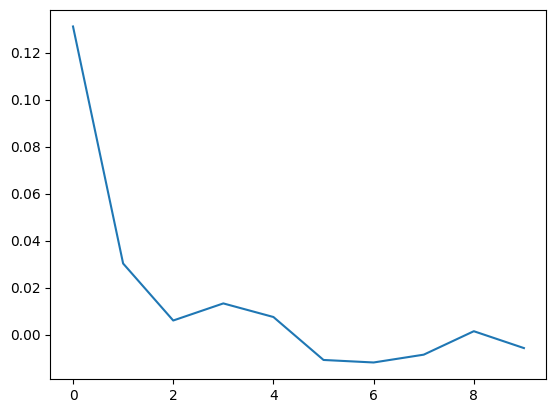

In [59]:
plt.plot(E_eval.features['percussive_beat_frames_svd'][0])

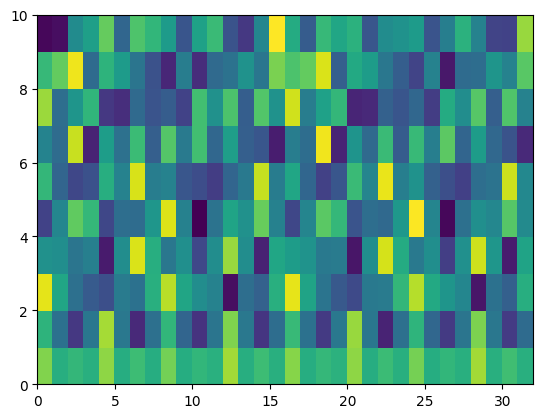

In [60]:
plt.pcolor(Extractor._stateful_extractors['percussive_beat_frames_svd'][0].components_)